# MC of a Compton interaction: part II

## Introduction

In the previous part, you implemented a method to sample the distance travelled before a compton interaction and the $\theta$ and $\phi$ scatter angle, after the interaction has taken place.

Now we can put everything together and run our small MC experiment. 


#### packages

In [1]:
import numpy as np
import sympy
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
import utils

## 1. MC simulation

In [2]:
def mc_compton(n, incoming_energy_keV, mu, thickness_slab, z_d, xs_detector, ys_detector, pixelsize):
    """ Simulate N Compton events 
    
    INPUT
    * n = number of iterations
    * incoming_energy_keV = the energy of the incoming photon in keV
    * mu = the cross section for compton in 1/cm
    * thickness_slab = the thickness of the material in cm
    * z_d = the position of the detector in cm
    * xs_detector = the length of the detector in cm in the x direction
    * ys_detector = the length of the detector in cm in the y direction
    * pixelsize = the x and y length of a pixel in cm
    
    return: /
    """
    
    mec2 = 5.11e5 # rest energy electron eV
    kappa = lambda E: E * 1000/mec2  # a function that calculates kappa from an incoming energy E in keV
    # We will keep track of how many photons are 
    # - rejected when doing the angle sampling, 
    # - considered primaries (and therefore ignored) 
    # - or are scattered out of bounce
    n_out_of_bounce = 0
    n_rejected = 0
    n_primary = 0 
    
    # get the pdf distribution for the energy of the incoming photon, calculate kappa for this energy and initialise the image
    pdf, min_tau, max_tau = utils.get_pdf(incoming_energy_keV)
    kappa_v = kappa(incoming_energy_keV)
    im = utils.Image(xs_detector=xs_detector, ys_detector=ys_detector,pixelsize=pixelsize)
    
    # Run the events 
    for i in range(n):
        # compton interaction in the slab
        s = utils.distance_travelled_before_interaction(mu)
        if s>thickness_slab:
            n_primary +=1
            continue
        co_i = np.array([0,0,s[0]])
        
        # compton interaction in the slab
        res, tau_out = utils.rejection_sampling(min_tau, max_tau, pdf)
        if res:
            # Get the angles
            phi_out = utils.get_phi()
            theta_out = utils.get_theta(tau_out, kappa_v)
            # Get the direction
            d = utils.get_direction(phi_out, theta_out) 
            # Get the position of the scattered photon on the detector
            co_e = utils.get_detector_position_co(co_i, d, z_detector=z_d, xs_detector=im.xs_detector, ys_detector=im.ys_detector)
            if co_e is not None:
                im.add_count(co_e)
            else:
                n_out_of_bounce +=1
        else:
            n_rejected +=1 


    # Show the image
    plt.imshow(im.image)
    plt.show()
    
    # Calculate the rejection rates
    if n==n_primary:
        rejectionrate = 0
    else:
        rejectionrate = np.round(n_rejected/(n-n_primary)*100)
    if n==n_primary+n_rejected: 
        outofbouncerate = 0
    else:
        outofbouncerate = np.round(n_out_of_bounce/(n-n_primary-n_rejected)*100)
    primaryrate = np.round(n_primary/n*100)
    print('Angle rejection Rate = ', rejectionrate,'%, out of bounce rate=', outofbouncerate ,'% Primary rate=', primaryrate , ' %')

**excercise:** Explain
1. The effect of energy on the rejection rate when sampling $\theta $. 
2. The effect of slab thickness on the primary rate.
3. The effect of detector distance on the out of bounce rate and primary rate

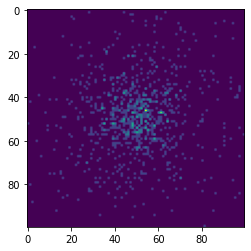

Angle rejection Rate =  60.0 %, out of bounce rate= 40.0 % Primary rate= 81.0  %


In [3]:
incoming_energy_keV = 1000
mu = utils.get_compton_crosssection(incoming_energy_keV, atomic_number=20, density=1.63)

mc_compton(n=20000,
           incoming_energy_keV= incoming_energy_keV, 
           mu=mu, 
           thickness_slab = 2, 
           z_d=23, 
           xs_detector=100, 
           ys_detector=100, 
           pixelsize=1)